# HARQ допуск №1

### Импорт библиотек

In [ ]:
import timeit

In [2]:
from scipy.stats import norm
import numpy as np
import numpy.polynomial.polynomial as poly
import plotly.graph_objects as go

In [3]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

#### Функция моделирования канала

In [4]:
def channel_modeling(SNRdB: np.ndarray, n_exp: int, messages: np.ndarray, codewords_bits: np.ndarray, codewords: np.ndarray, g_x: np.ndarray):
    
    Pe_bit, Ped, Ped_theor = np.zeros(SNRdB.size), np.zeros(SNRdB.size), np.zeros(SNRdB.size)
    
    r = g_x.size - 1
    n = codewords_bits.shape[1]
    
    SNR = 10 ** (SNRdB / 10)
    for i in range(SNR.size):
        starttime = timeit.default_timer()

        sigma = np.sqrt(1 / (2 * SNR[i]))
        nTests = nErr = nErrBits = 0
    
        while nTests < n_exp:
            message_index = np.random.randint(0, messages.shape[0])
            c_x = codewords_bits[message_index]                         # CRC
            c = codewords[message_index]                                # BPSK
            c_AWGN = c + (sigma * np.random.randn(n))                   # Channel AWGN
            c_x_AWGN = (c_AWGN > 0).astype('int32')                     # unBPSK
            s = np.mod(poly.polydiv(c_x_AWGN, g_x), 2)[1].max() == 1    # unCRC
    
            # Counting errors
            v = (c_x.astype('int32') ^ c_x_AWGN).sum()
            nErrBits = nErrBits + v
            if not s and (v > 0):
                nErr = nErr + 1
            nTests = nTests + 1

        Ped[i] = nErr / nTests
        Pe_bit[i] = nErrBits / (nTests * n)
        print('[{}/{}]\tSNRdB = {}\tВремя выполнения : {:.1f}с'.format(i + 1, SNR.size, SNRdB[i], timeit.default_timer() - starttime))

    Pe_bit_theor = norm.sf(np.sqrt(2 * SNR))
    Ped_theor_up = np.ones(SNR.size) * (1 / 2 ** r)

    w = np.sum(codewords_bits[1:], axis=1)
    d = int(np.min(w))

    for i in range(SNR.size):
        Pe_theoretical = 0
        for j in range(d, n + 1):
            Pe_theoretical = Pe_theoretical + np.sum(w == j) * (Pe_bit_theor[i] ** j) * ((1 - Pe_bit_theor[i]) ** (n-j))
        Ped_theor[i] = Pe_theoretical

    return Pe_bit, Ped, Ped_theor, Ped_theor_up, Pe_bit_theor

#### Инициализация порождающего многочлена и количества сообщений

In [5]:
g_x = np.flip(np.array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]))  # [3, 2, 1] даст 1 + 2*x + 3*x**2.
k = 8  # 2^k сообщений

#### Загрузка заранее созданных таблиц

In [6]:
messages = np.load('./../Tables/messages_2^{}.npy'.format(k))
codewords_bits = np.load('./../Tables/codewords_bits_2^{}.npy'.format(k))
codewords = np.load('./../Tables/codewords_2^{}.npy'.format(k))

#### Инициализация количества сообщений и масива уровней сигнал/шум

In [7]:
eps = 0.01
# N = int(9 / (4 * eps * eps))
N = 250_000
SNRdB = np.arange(-30, 11, 5)

#### Моделирование канала

In [8]:
Pe_bit, Ped, Ped_theor, Ped_theor_up, Pe_bit_theor = channel_modeling(SNRdB, N, messages, codewords_bits, codewords, g_x)

[1/9]	SNRdB = -30	Время выполнения : 46.5с
[2/9]	SNRdB = -25	Время выполнения : 58.3с
[3/9]	SNRdB = -20	Время выполнения : 51.8с
[4/9]	SNRdB = -15	Время выполнения : 42.0с
[5/9]	SNRdB = -10	Время выполнения : 41.5с
[6/9]	SNRdB = -5	Время выполнения : 41.3с
[7/9]	SNRdB = 0	Время выполнения : 40.7с
[8/9]	SNRdB = 5	Время выполнения : 41.1с
[9/9]	SNRdB = 10	Время выполнения : 41.4с


#### График вероятности ошибки декодирования

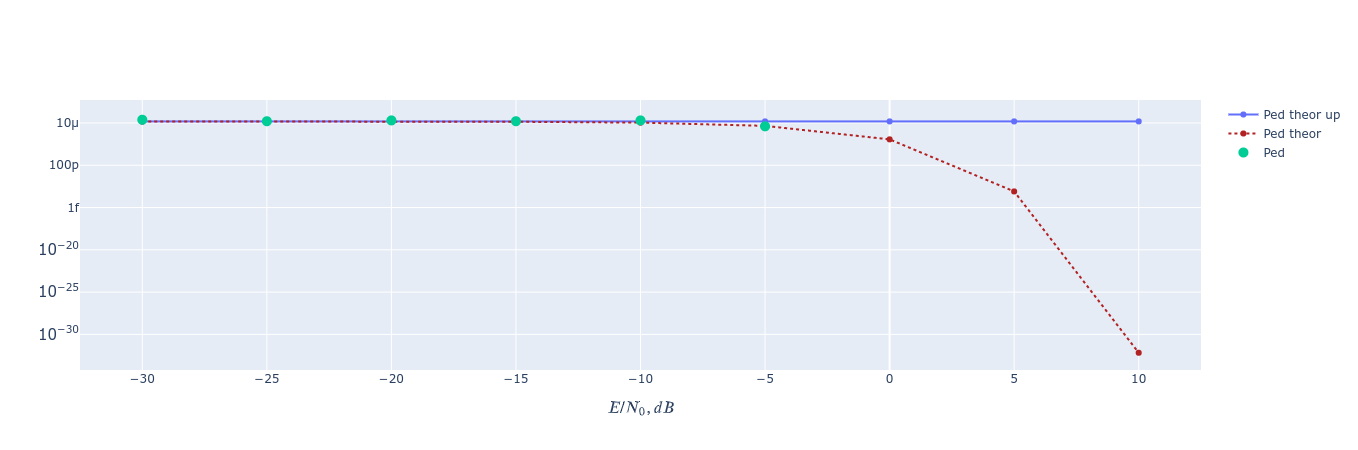

In [9]:
fig_ped = go.Figure()
fig_ped.add_trace(go.Scatter(x=SNRdB, y=Ped_theor_up, name='Ped theor up'))
fig_ped.add_trace(go.Scatter(x=SNRdB, y=Ped_theor, line=dict(color='firebrick', dash='dot'), name='Ped theor'))
fig_ped.add_trace(go.Scatter(x=SNRdB, y=Ped, mode='markers', name='Ped', marker=dict(size=10)))
fig_ped.update_layout(xaxis_title='$E/N_0, dB$', yaxis_type="log")
fig_ped.show()

#### График вероятности ошибки на бит

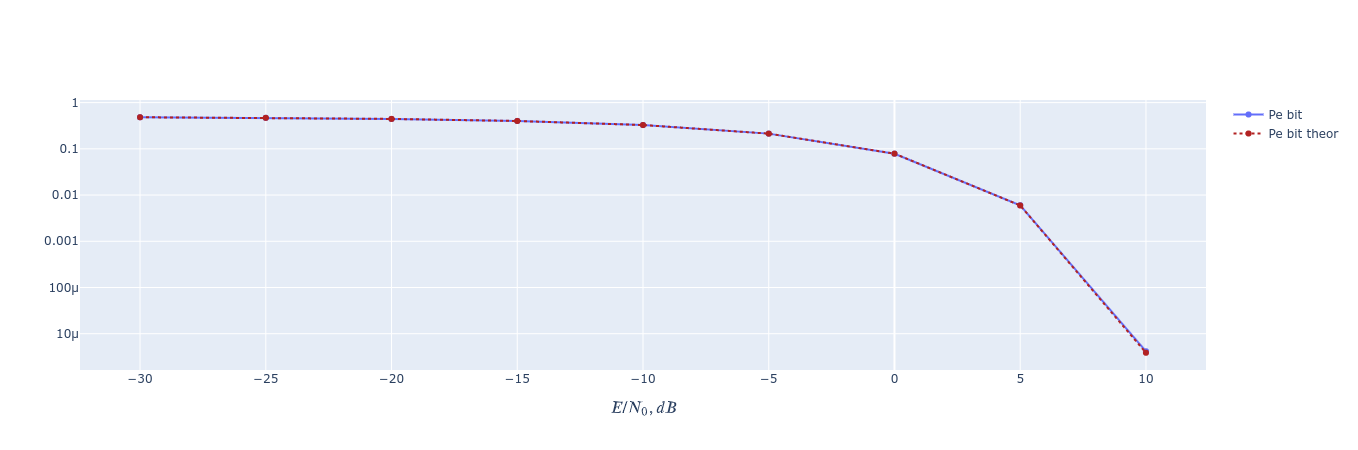

In [10]:
fig_pe_bit = go.Figure()
fig_pe_bit.add_trace(go.Scatter(x=SNRdB, y=Pe_bit, mode='lines+markers', name='Pe bit'))
fig_pe_bit.add_trace(go.Scatter(x=SNRdB, y=Pe_bit_theor, line=dict(color='firebrick', dash='dot'), name='Pe bit theor'))
fig_pe_bit.update_layout(xaxis_title='$E/N_0, dB$', yaxis_type="log")
fig_pe_bit.show()